In [13]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

from scipy.optimize import minimize

In [14]:
num_qubits = 4

In [15]:
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]

    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)


hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

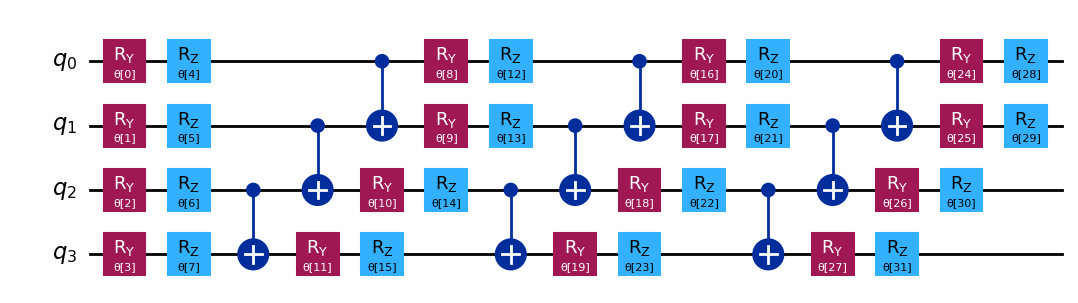

In [16]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(hamiltonian.num_qubits).decompose()

ansatz.draw("mpl")

In [17]:
weights = np.arange(num_qubits, 0, -1)

print(weights)

[4 3 2 1]


In [18]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)],
}


def initialize_cost_history_dict():
    cost_history_dict["prev_vector"] = None
    cost_history_dict["iters"] = 0
    cost_history_dict["total_energy"] = []
    cost_history_dict["eigenstates_energies"] = [[] for _ in range(num_qubits)]

## Weighted sum of expectation values
$\text{SSVQE\_Cost}(\theta) = \sum_k w_k \langle \psi_k(\theta) | H | \psi_k(\theta) \rangle$

In [19]:
def ssvqe_cost_func(params, ansatz, hamiltonian, estimator, initial_states, weights):
    pubs = []

    for init_state in initial_states:
        full_circuit = init_state.compose(ansatz)
        pubs.append((full_circuit, [hamiltonian], [params]))

    result = estimator.run(pubs=pubs).result()
    energies = [r.data.evs[0] for r in result]

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["total_energy"].append(weighted_energy)

    for i in range(num_qubits):
        cost_history_dict["eigenstates_energies"][i].append(energies[i])

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")

    return weighted_energy

## Real Hardware

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

service = QiskitRuntimeService(
    channel="ibm_quantum", instance="yonsei-dedicated/internal/ybscandid"
)
backend = service.backend("ibm_yonsei")
print(backend.name)

ibm_yonsei


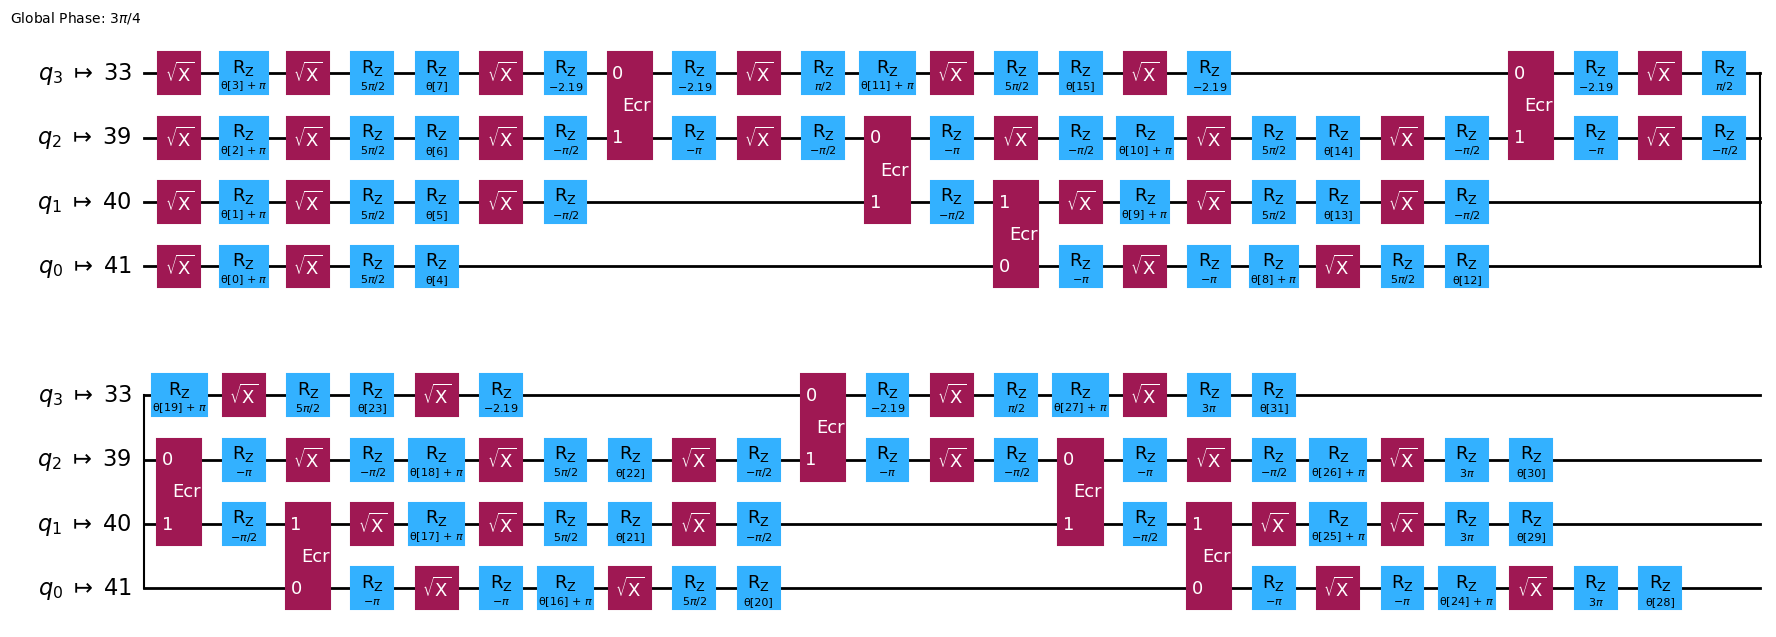

In [21]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [22]:
layout = ansatz_isa.layout
initial_states_isa = []

for i in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - i)
    qc_isa = pm.run(qc)
    initial_states_isa.append(qc_isa)

hamiltonian_isa = hamiltonian.apply_layout(layout=layout)

In [ ]:
params_init = np.random.rand(ansatz.num_parameters) * 2 * np.pi
initialize_cost_history_dict()

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    estimator.options.resilience_level = 2

    result = minimize(
        ssvqe_cost_func,
        params_init,
        args=(
            ansatz_isa,
            hamiltonian_isa,
            estimator,
            initial_states_isa,
            weights,
        ),
        method="COBYLA",
        options={"maxiter": 500},
    )

[Iter 1] Cost: 4.978938
[Iter 2] Cost: -0.947524
[Iter 3] Cost: -5.604912
[Iter 4] Cost: 0.446052
[Iter 5] Cost: -5.400199
[Iter 6] Cost: -5.094675
[Iter 7] Cost: -5.473384
[Iter 8] Cost: -1.907442
[Iter 9] Cost: -3.656508
[Iter 10] Cost: 0.800791
[Iter 11] Cost: -5.828961
[Iter 12] Cost: -6.406305
[Iter 13] Cost: -3.679176
[Iter 14] Cost: -6.757977
[Iter 15] Cost: -9.517107
[Iter 16] Cost: -5.099768
[Iter 17] Cost: -7.009251
[Iter 18] Cost: -6.465656
[Iter 19] Cost: -7.887110
[Iter 20] Cost: -10.407721
[Iter 21] Cost: -10.417955
[Iter 22] Cost: -6.934460
[Iter 23] Cost: -7.253609
[Iter 24] Cost: -4.316098
[Iter 25] Cost: -8.126141
[Iter 26] Cost: -8.437776
[Iter 27] Cost: -6.108553
[Iter 28] Cost: -9.488338
[Iter 29] Cost: -10.191837
[Iter 30] Cost: -11.957806
[Iter 31] Cost: -11.212140
[Iter 32] Cost: -11.567750
[Iter 33] Cost: -10.246297
[Iter 34] Cost: -7.612608
[Iter 35] Cost: -12.415267
[Iter 36] Cost: -8.287979
[Iter 37] Cost: -14.770840
[Iter 38] Cost: -5.661642
[Iter 39] Cost:

0th Converged Energy : -4.0322931832323965
1th Converged Energy : -4.054546776793532
2th Converged Energy : -4.107411884189079
3th Converged Energy : -4.082965570189404


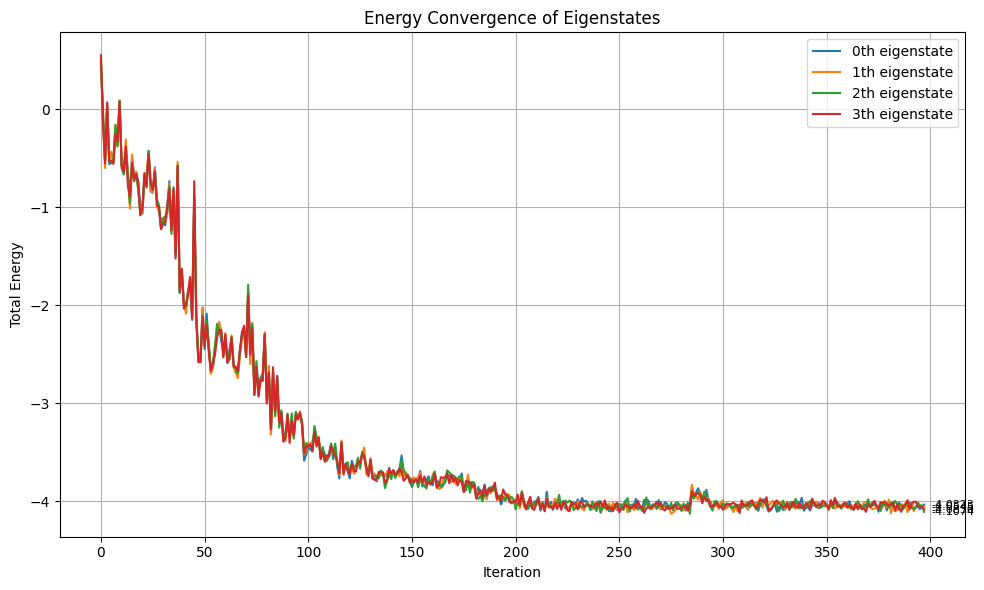

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(num_qubits):
    energy_curve = cost_history_dict["eigenstates_energies"][i]
    plt.plot(energy_curve, label=f"{i}th eigenstate")

    final_iters = cost_history_dict["iters"] - 1
    converged_energy = energy_curve[final_iters]

    print(f"{i}th Converged Energy : {converged_energy}")

    plt.annotate(
        f"{converged_energy:.4f}",
        xy=(final_iters, converged_energy),
        xytext=(5, 0),
        textcoords="offset points",
        ha="left",
        va="center",
        fontsize=8,
        color="black",
    )

plt.xlabel("Iteration")
plt.ylabel("Total Energy")
plt.title("Energy Convergence of Eigenstates")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()